In [1]:
from mr_eval.utils.utils import *
import os
import plotly
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import json
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
from matplotlib import font_manager

def list_jsonl_files(folder_path):
    """
    列举文件夹中的所有 .jsonl 文件
    Args:
        folder_path (str): 文件夹路径
    Returns:
        List[str]: 所有 .jsonl 文件的路径
    """
    return [f for f in os.listdir(folder_path) if f.endswith(".jsonl")]


## Model names
prm_model_name_dict = dict(
    skyworkprm_1_5B="Skywork-1.5B",
    skyworkprm_7B="Skywork-PRM-7B",
    llemma7b_prm_prm800k="Llemma-PRM800k-7B",
    llemma7b_prm_metamath="Llemma-MetaMath-7B",
    llemma7b_oprm_prm800k="Llemma-oprm-7B",
    mathminos_mistral="MATHMinos-7B",
    mathshepherd="MathShepherd-7B",
    reasoneval7b="ReasonEval-7B",
    llama3_1_8b_prm_mistral="RLHFlow-PRM-Mistral-8B",
    llama3_1_8b_prm_deepseek="RLHFlow-PRM-Deepseek-8B",
    reasoneval34b="ReasonEval-34B",
)
close_model_name_dict = dict(
    gpt4o="GPT-4o",
    o1mini="o1-mini",
    o1preview="o1-preview",
    gemini_2_flash="Gemini-2.0-flash-exp",
    gemini_2_thinking="Gemini-thinking",
)
    
open_model_name_dict = dict(
    qwen_qwq="QwQ-Preview-32B",
)

all_model_name_dict = prm_model_name_dict | close_model_name_dict | open_model_name_dict


classification_name_dict = dict(
    domain_inconsistency="DC.",
    redundency="NR.",
    multi_solutions="MS.",
    deception="DR.",
    confidence="CI.",
    step_contradiction="SC.",
    circular="NCL.",
    missing_condition="PS.",
    counterfactual="ES."
)
classification_parallel_dict = dict(
    simplicity=dict(
        redundency="NR.",
        circular="NCL.",
    ),
    soundness=dict(
        counterfactual="ES.",
        step_contradiction="SC.",
        domain_inconsistency="DC.",
        confidence="CI.",
    ),
    sensitivity=dict(
        missing_condition="PS.",
        deception="DR.",
        multi_solutions="MS.",
    )
)
classification_parallel_dict["all"] = classification_parallel_dict["simplicity"] | classification_parallel_dict["soundness"] | classification_parallel_dict["sensitivity"]
classifications = ["redundency", "counterfactual", "step_contradiction", "domain_inconsistency",  "confidence", "missing_condition", "deception", "multi_solutions", "circular" ]
metrics = ["f1", "negative_f1", "total_step_acc", "correct_step_acc", "wrong_step_acc", "first_error_acc", "similarity",]





def get_res_dict(file_dict,model_lists=None):
    res_dict = {}
    if not model_lists:
        for model_name, file_path in file_dict.items():
            res_dict[model_name] = process_jsonl(file_path)[-1]
    else:
        for model_name in model_lists:
            file_path = file_dict[model_name]
            res_dict[model_name] = process_jsonl(file_path)[-1]
    return res_dict


def get_prmscore_from_current_res_dict(res_dict,classification=None):
    '''
    Get PRM score from model level dict
    '''
    if not classification:
        prm_score = res_dict["total_hallucination_results"]['f1'] * 0.5 + res_dict["total_hallucination_results"]['negative_f1'] * 0.5
    else:
        if classification in ["multi_solutions"]:
            prm_score = res_dict["hallucination_type_results"]['f1'][classification]
        else:
            prm_score = res_dict["hallucination_type_results"]['f1'][classification] * 0.5 + res_dict["hallucination_type_results"]['negative_f1'][classification] * 0.5
    return prm_score


def get_avg_prmscore_from_current_res_dict(res_dict,classifications):
    '''
    Get AVG PRM score from model level dict
    '''
    assert classifications
    res = [get_prmscore_from_current_res_dict(res_dict,classification) for classification in classifications]
    return sum(res) / len(res)
    

def get_res_str(model_dict,classification_dict,res_dict):
    res_str = ""
    # current_classification_dict = classification_dict[classification_name]
    for model_name, model_display_name in model_dict.items():
        temp_str = f"{model_display_name}"
        current_res_dict = res_dict[model_name]
        prm_score = get_prmscore_from_current_res_dict(current_res_dict)
        all_model_scores = sorted([get_prmscore_from_current_res_dict(res) for res in res_dict.values()],reverse=True)
        if prm_score == max(all_model_scores):
            temp_str += f" & \\textbf{{{prm_score * 100:.1f}}}"
        elif prm_score == all_model_scores[1]:
            temp_str += f" & \\underline{{{prm_score * 100:.1f}}}"
        else:
            temp_str += f" & {prm_score * 100:.1f}"
        
        for big_classification, current_classification_dict in classification_dict.items():
            all_avt = sorted([get_avg_prmscore_from_current_res_dict(res,list(current_classification_dict.keys())) for res in res_dict.values()], reverse=True)
            avg = []
            for classification, display_classification_name in current_classification_dict.items():
                prm_score = get_prmscore_from_current_res_dict(current_res_dict,classification)
                all_prm_scores = sorted([get_prmscore_from_current_res_dict(res,classification) for res in res_dict.values()], reverse=True)
                avg.append(prm_score)
                if prm_score == max(all_prm_scores):
                    temp_str += f" & \\textbf{{{prm_score * 100:.1f}}}"
                elif prm_score == all_prm_scores[1]:
                    temp_str += f" & \\underline{{{prm_score * 100:.1f}}}"
                else:
                    temp_str += f" & {prm_score * 100:.1f}"
            avg_score = sum(avg) / len(avg)
            if avg_score == max(all_avt):
                temp_str += f" & \\textbf{{{avg_score * 100:.1f}}}"
            elif avg_score == all_avt[1]:
                temp_str += f" & \\underline{{{avg_score * 100:.1f}}}"
            else:
                temp_str += f" & {avg_score * 100:.1f}"
        temp_str += "\\\\\n"
        res_str += temp_str
    return res_str

In [2]:
## File paths
res_dir = "/mnt/petrelfs/songmingyang/code/reasoning/MR_Hallucination/mr_eval/scripts/logs/prmtest_classified"
res_files = list_jsonl_files(res_dir)
res_names = [f.split(".")[0] for f in res_files]
res_paths = [os.path.join(res_dir, f) for f in res_files]
file_dict = dict(zip(res_names, res_paths))
res_dict = get_res_dict(file_dict)
draw_point_dict = {k:[] for k in list(res_dict.keys())}
for model_name, current_res_dict in res_dict.items():
    for classification in list(classifications):
        draw_point_dict[model_name].append(get_prmscore_from_current_res_dict(current_res_dict,classification)*100)

display_model_list = ["reasoneval34b","mathminos_mistral","mathshepherd","skyworkprm_1_5B","gemini_2_thinking","o1mini","gpt4o"]
# Colors 

radar_labels = [classification_name_dict[i] for i in classifications]
radar_dims = len(radar_labels)
max_data = 100
theta = np.linspace(0, 2 * np.pi, radar_dims, endpoint=False).tolist()
line_styles = ['-', '--',]
markers = ['o', 's', '^',]  # 圆形、方形、三角形、菱形
fill_color = "#b5b1b1"
# 将数据补齐闭合雷达图
for model_name, data in draw_point_dict.items():
    draw_point_dict[model_name].append(draw_point_dict[model_name][0])
theta.append(theta[0])

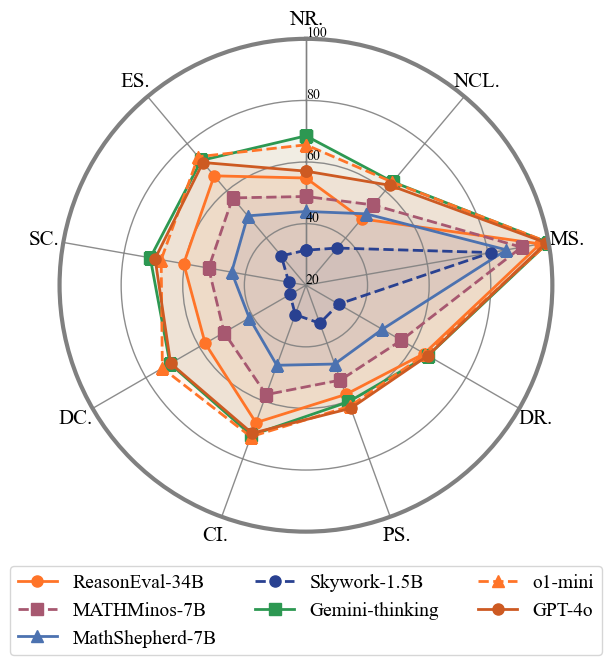

In [5]:
soft_palette = [
    "#ff7428",  # 柔和cheng
    "#a75870",   # 柔和紫
    "#4c72b0",  # 柔和蓝
    "#294191" ,  # 柔和深蓝
    "#2d9852",  # 柔和绿
    "#ff7428",  # 柔和cheng
    "#cd5a22",  # 柔和红
    
    "#fbcd6f", # 柔和黄
    "#2d9852",  # 柔和绿
    "#335b88",  # 柔和hui
    "#4c72b0",  # 柔和蓝
    "#fce5ae", # 柔和黄
    "#64b5cd",   # 柔和青
    "#cd5a22",  # 柔和红
]

font_path = '/mnt/petrelfs/songmingyang/code/tools/tool_code/result_dealing/draw_fig/Comic Sans MS.ttf'  
font_path = "/mnt/petrelfs/songmingyang/.config/fonts/Times New Roman.ttf"
custom_font = font_manager.FontProperties(fname=font_path,size=14)

# 创建图形
fig, ax = plt.subplots(figsize=(6.4, 6.4), subplot_kw={'projection': 'polar'})
# 画标签
yticks = [20,40,60,80,100]
ax.set_yticks([20,40,60,80,100]) 
ax.set_yticklabels([])
for i, ytick in enumerate(yticks):
    ax.text(0, ytick+2, f"{ytick}", fontsize=10, color="black", ha="left", va="center", fontproperties=custom_font)
    
# 绘制雷达图
for idx,model_name in enumerate(display_model_list):
    data = draw_point_dict[model_name]
    display_name = all_model_name_dict.get(model_name,model_name)
    current_color = soft_palette[idx%len(soft_palette)]
    ax.fill(theta, data, alpha=0.07, color=current_color)
    ax.plot(theta, data, label=display_name, linewidth=2, linestyle=line_styles[idx%len(line_styles)], marker=markers[idx%len(markers)], markersize=8, color=soft_palette[idx%len(soft_palette)])



# rotate_labels = benchmarks
ax.set_thetagrids(angles=np.linspace(0, 360, radar_dims+1), labels=radar_labels+[""])
ax.set_theta_offset(np.pi / 2)  # 将起始角度设置为 90 度（正上方）
labels = ax.get_xticklabels()
# font_path = './Times New Roman.ttf'
# font_prop = FontProperties(fname=font_path)
for label in labels:
    label.set_fontsize(12)  # 设置字体大小
    label.set_color('black')  # 设置字体颜色
    label.set_fontproperties(custom_font)  # 设置字体类型



# ax.set_rgrids(np.arange(0.85, 1.02, 0.05),)  # 例如，设置每0.2单位一条径向网格线
plt.grid(True, color='black', linestyle='--', linewidth=1, alpha=0.9)
# 设置背景颜色、网格线颜色、以及图形属性
ax.set_facecolor('white')
ax.xaxis.grid(True, color='gray', linestyle='-')
ax.yaxis.grid(True, color='gray', linestyle='-')
ax.spines['polar'].set_color('gray')  # 设置最外圈颜色
ax.spines['polar'].set_linewidth(3)    # 设置最外圈线宽
ax.spines['polar'].set_visible(True)

# 设置极轴的范围
ax.set_ylim(20,100)

# 设置角度标签的字体大小
ax.tick_params(axis='x', which='major', labelsize=15)

# 添加图例
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, frameon=True,fontsize=15,prop = custom_font)
fig.savefig('./res/llava_radar.pdf', format='pdf',bbox_inches='tight')
fig.savefig('./res/llava_radar.svg', format='svg',bbox_inches='tight')
# 显示图形
plt.show()

In [54]:
print(f"len of base_data: {len(base_data)} len of rbase: {len(r_base)}, len of theta: {len(theta)}, len of rbalance: {len(r_balanced)}")

len of base_data: 16 len of rbase: 17, len of theta: 17, len of rbalance: 17


In [16]:

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      mode='lines+text',
      r=[i/j for i,j in zip(base_data+[base_data[0]],aug_data+[aug_data[0]])],
      theta= benchmarks + [benchmarks[0]],
      fill= 'toself',
      name= 'Base',
      line=dict(color='orange', dash='solid'),
      text=[f"{i:.1f}" for i in base_data+[base_data[0]]],
      textposition='middle left',
      textfont=dict(color='orange') 
))
fig.add_trace(go.Scatterpolar(
      mode='lines+text',
      r=[i/j for i,j in zip(balanced_data+[balanced_data[0]],aug_data+[aug_data[0]])],
      theta= benchmarks + [benchmarks[0]],
      fill= 'none',
      name= 'Balanced',
      line=dict(color='green', dash='solid'),
      text=[f"{i:.1f}" for i in balanced_data+[balanced_data[0]]],
      textposition='middle right',
      textfont=dict(color='green') 
))

fig.add_trace(go.Scatterpolar(
      mode='lines+text',
      r=[i/j for i,j in zip(aug_data+[aug_data[0]],aug_data+[aug_data[0]])],
      theta= benchmarks + [benchmarks[0]],
      fill= 'none',
      name= 'Ours',
      line=dict(color='blue', dash='solid'),
      text=[f"{i:.1f}" for i in aug_data+[aug_data[0]]],
      textposition='middle left',
      textfont=dict(color='blue') 
))



fig.update_layout(
    polar=dict(
        bgcolor='white',
        radialaxis=dict(
            visible=True,
            showgrid=True,
            gridcolor='lightgray',  # 设置径向网格线的颜色
            showticklabels=False,
            tickvals=[0.85, 0.9, 0.95, 1.0, 1.02],  # 设置径向网格线的间距
            range=[0.85, 1.02],
            
        ),
        angularaxis=dict(
            tick0='auto',
            tickfont=dict(size=15),  # 设置分类标签的字体大小
            showgrid=True,
            gridcolor='lightgray',  # 设置角度网格线的颜色
            linecolor='black',  # 设置最外圈的颜色为黑色
            linewidth=1  # 设置最外圈的线宽为2
        )

    ),
    showlegend=True,
    legend=dict(
        x=0.5,  # 调整图例的水平位置
        y=-0.1,  # 调整图例的垂直位置
        bgcolor='rgba(255, 255, 255, 0.6)',  # 设置图例的背景颜色及透明度
        bordercolor='rgba(0, 0, 0, 0.1)',  # 设置图例的边框颜色为黑色
        borderwidth=2,  # 设置图例的边框宽度为2像素
        xanchor='center',  # 图例的x锚点为中心
        yanchor='top',     # 图例的y锚点为顶部
        orientation='h',   # 图例水平排列
        traceorder="normal",  # 控制图例中图例项的顺序
        font=dict(  # 设置图例文字的属性
            # family="Times New Roman",  # 设置字体
            size=13,  # 设置文字大小
            color="black"  # 设置文字颜色
        ),
        itemsizing='trace'  # 设置图例项的大小为常量
    ),
  
    
    height=640,  # 设置画布高度
    width=640  # 设置画布宽度
)


fig.show()
pio.write_image(fig, f"res/llava_radar.pdf")


NameError: name 'go' is not defined

In [ ]:

eval_type_dict = {
    "Perception": [
        "existence",
        "count",
        "position",
        "color",
        "posters",
        "celebrity",
        "scene",
        "landmark",
        "artwork",
        "OCR",
    ],
    "Cognition": [
        "commonsense_reasoning",
        "numerical_calculation",
        "text_translation",
        "code_reasoning",
    ],
}

low_resource = "bn ta ur ml mr te gu my jv sw".split()
medium_resource = "id sv ar fa ko el th uk bg hi".split()
high_resource = "en ru de zh ja fr es it nl pt vi ".split()


type_list = eval_type_dict["Perception"] + eval_type_dict["Cognition"]

metric_list=[]
for i in type_list:
    metric_list.append(i+"_acc")
    # metric_list.append(i+"_acc_plus")
# metric_list.append("percetion_score")
# metric_list.append("cognition_score")

In [4]:
def get_data_by_lang(lang,input_json_file_path, metric_list=metric_list):
    with open(input_json_file_path, 'r') as f:
        result = json.load(f)
    result_data = result["results"]
    
    language_index = f"mme_mul_{lang}"
    result_chart = {}
    for metric in metric_list:
        metric_index = f"mme_{metric},none"
        result_chart[metric]=result_data[language_index][metric_index]
    
    return result_chart

In [20]:

language = "uk"
math_tasks_categories = ['Ambiguity', 'Duration', 'Frequency', 'Causality', 'Nli', 'Ordering', 'Relation', 'Storytelling', 'Ambiguity (Math)', 'Arithmetic (Math)', 'Duration (Math)', 'Frequency (Math)', 'Typical time']
math_tasks_categories = ["Existence",
        "Count",
        "Position",
        "Color",
        "Posters",
        "Celebrity",
        "Scene",
        "Landmark",
        "Artwork",
        "OCR","Commonsense Reasoning",
        "Numerical Calculation",
        "Text Translation",
        "Code Reasoning",
        ]
baseline_results_chart = get_data_by_lang(language, baseline_result_data_file)
bleu_results_chart = get_data_by_lang(language, loss_t_1101_24k)
trans_results_chart = get_data_by_lang(language,trans)
mblip_results_chart = get_data_by_lang(language,mblip)

baseline_results_list = [v for _,v in baseline_results_chart.items()]
bleu_results_list = [v for _,v in bleu_results_chart.items()]
trans_results_list = [v for _,v in trans_results_chart.items()]
mblip_results_list = [v for _,v in mblip_results_chart.items()]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      mode='lines+text',
      r=[i/j for i,j in zip(baseline_results_list+[baseline_results_list[0]],bleu_results_list+[bleu_results_list[0]])],
      theta= math_tasks_categories + [math_tasks_categories[0]],
      fill= 'toself',
      name= 'Base',
      line=dict(color='orange', dash='solid'),
      text=[f"{i:.1f}" for i in baseline_results_list+[baseline_results_list[0]]],
      textposition='middle left',
))

fig.add_trace(go.Scatterpolar(
      mode='lines+text',
      r=[i/j for i,j in zip(bleu_results_list+[bleu_results_list[0]],bleu_results_list+[bleu_results_list[0]])],
      theta= math_tasks_categories + [math_tasks_categories[0]],
      fill= 'none',
      name= 'Ours',
      line=dict(color='blue', dash='solid'),
      text=[f"{i:.1f}" for i in bleu_results_list+[bleu_results_list[0]]],
      textposition='middle left',
))

# fig.add_trace(go.Scatterpolar(
#       mode='lines+text',
#       r=[i/j for i,j in zip(trans_results_list+[trans_results_list[0]],bleu_results_list+[bleu_results_list[0]])],
#       theta= math_tasks_categories + [math_tasks_categories[0]],
#       fill= 'none',
#       name= 'Trans',
#       line=dict(color='pink', dash='solid'),
#       text=[f"{i:.1f}" for i in trans_results_list+[trans_results_list[0]]],
#       textposition='middle left',
# ))

# fig.add_trace(go.Scatterpolar(
#       mode='lines+text',
#       r=[i/j for i,j in zip(mblip_results_list+[mblip_results_list[0]],bleu_results_list+[bleu_results_list[0]])],
#       theta= math_tasks_categories + [math_tasks_categories[0]],
#       fill= 'none',
#       name= 'MBLIP',
#       line=dict(color='green', dash='solid'),
#       text=[f"{i:.1f}" for i in trans_results_list+[trans_results_list[0]]],
#       textposition='middle left',
# ))



fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True, 
            showgrid=True,
            showticklabels=False,
            range=[0.5, 1.05]
        ),
        angularaxis=dict(
            tick0='auto',
            tickfont=dict(size=18)  # 设置分类标签的字体大小
        )
    ),
    showlegend=True,
    legend=dict(
        # x=0.95,  # 调整图例的水平位置
        # y=-0.15,  # 调整图例的垂直位置
        # bgcolor='rgba(255, 255, 255, 0.6)',  # 设置图例的背景颜色及透明度
        # bordercolor='rgba(0, 0, 0, 0.2)',  # 设置图例的边框颜色及透明度
        # borderwidth=2,  # 设置图例的边框宽度
        traceorder="normal",  # 控制图例中图例项的顺序
        font=dict(  # 设置图例文字的属性
            # family="Times New Roman",  # 设置字体
            size=20,  # 设置文字大小
            color="black"  # 设置文字颜色
        ),
        itemsizing='trace'  # 设置图例项的大小为常量
    ),
    
    height=620,  # 设置画布高度
    width=760  # 设置画布宽度
)


fig.show()
pio.write_image(fig, f"res/radar_{language}.pdf")


In [47]:


math_tasks_categories = ['Ambiguity', 'Duration', 'Frequency', 'Causality', 'Nli', 'Ordering', 'Relation', 'Storytelling', 'Ambiguity (Math)', 'Arithmetic (Math)', 'Duration (Math)', 'Frequency (Math)', 'Typical time']

llama_data = [70.0, 74.4, 80.5, 90.5, 50.0, 40.0, 44.0, 67.0, 52.3, 60.9, 58.5, 70.0, 82.0]
llama_data_text = [86.0, 77.4, 87.5, 95.5, 55.0, 44.0, 44.0, 71.0, 61.3, 63.9, 58.5, 81.0, 82.0]
mathllama_data = [80.0, 62.4, 70.5, 97.5, 56.0, 45.0, 52.0, 75.0, 60.3, 69.0, 72.0, 80.5, 74.0]
mathllama_data_text = [88.0, 74.4, 84.5, 97.5, 56.0, 45.0, 52.0, 75.0, 64.3, 69.0, 72.0, 84.5, 78.0]
timo_data = [92.0, 78.2, 90.5, 97.5, 87.0, 79.5, 78.0, 83.0, 65.0, 66.3, 76.5, 85.5, 89.5]
timo_data_text = [92.0, 78.2, 90.5, 97.5, 87.0, 79.5, 78.0, 83.0, 65.0, 66.3, 76.5, 85.5, 89.5]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      mode='lines+text',
      r=[i/j for i,j in zip(llama_data + [llama_data[0]], timo_data + [timo_data[0]])],
      theta= math_tasks_categories + [math_tasks_categories[0]],
      fill= 'none',
      name= 'LLama-13B',
      line=dict(color='orange', dash='dot'),
      text=llama_data_text,
      textposition='middle left',
))

# fig.add_trace(go.Scatterpolar(
#       mode='lines+text',
#       r=[i/j for i,j in zip(mathllama_data + [mathllama_data[0]], timo_data + [timo_data[0]])],
#       theta= math_tasks_categories + [math_tasks_categories[0]],
#       fill= 'none',
#       name= 'MathLLama-13B',
#       line=dict(color='skyblue', dash='dot'),
#       text=mathllama_data_text,
#       textposition='middle left',
# ))

fig.add_trace(go.Scatterpolar(
      mode='lines+text',
      r=[i/j for i,j in zip(timo_data + [timo_data[0]], timo_data + [timo_data[0]])],
      theta= math_tasks_categories + [math_tasks_categories[0]],
      fill= 'none',
      name= 'Timo-13B',
      line=dict(color='mediumpurple', dash='solid'),
      text=timo_data_text,
      textposition='middle left',
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=False,
            range=[0.4, 1.05]
        ),
        angularaxis=dict(
            tick0='auto',
            tickfont=dict(size=18)  # 设置分类标签的字体大小
        )
    ),
    showlegend=True,
    legend=dict(
        x=0.8,  # 调整图例的水平位置
        y=-0.15,  # 调整图例的垂直位置
        bgcolor='rgba(255, 255, 255, 0.6)',  # 设置图例的背景颜色及透明度
        bordercolor='rgba(0, 0, 0, 0.2)',  # 设置图例的边框颜色及透明度
        borderwidth=2,  # 设置图例的边框宽度
        traceorder="normal",  # 控制图例中图例项的顺序
        font=dict(  # 设置图例文字的属性
            # family="Times New Roman",  # 设置字体
            size=18,  # 设置文字大小
            color="black"  # 设置文字颜色
        ),
        itemsizing='trace'  # 设置图例项的大小为常量
    ),
    height=620,  # 设置画布高度
    width=760  # 设置画布宽度
)


fig.show()


In [9]:
fig.write_image("llama&mathllama&timo.pdf")

In [13]:
import plotly.graph_objects as go

tasks_categories = ['MMLU', 'ARC', 'GSM8K', 'HellaSwag', 'TruthfulQA', 'WinoGranade', 'Temporal']

llama_data = [40.6, 40.1, 14.7, 40.7, 25.2, 50.2, 62.7]
llama_data_text = [46.6, 49.1, 14.7, 58.7, 25.2, 74.2, 70.7]
mathllama_data = [29.2, 47.3, 23.5, 46.3, 28.5, 53.3, 68.9]
mathllama_data_text = [46.2, 50.3, 24.5, 59.3, 28.5, 74.3, 72.9]
sft = [32.7, 42.4, 21.5, 52.5, 28.5, 50.2, 59.9]
sft_text = [46.3, 49.4, 21.5, 59.5, 28.5, 74.2, 69.9]
timo = [47.2, 53.3, 25.3, 60.8, 31.7, 75.8, 78.3]
timo_text = [47.2, 53.3, 25.3, 60.8, 31.7, 75.8, 78.3]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      mode='lines+text',
      r=[i/j for i,j in zip(llama_data + [llama_data[0]], timo + [timo[0]])],
      theta= tasks_categories + [tasks_categories[0]],
      fill= 'none',
      name= 'LLaMA',
      line=dict(color='orange', dash='dot'),
      text=llama_data_text,
      textposition='middle left',
))

fig.add_trace(go.Scatterpolar(
      mode='lines+text',
      r= [i/j for i,j in zip(mathllama_data+[mathllama_data[0]], timo + [timo[0]])],
      theta= tasks_categories + [tasks_categories[0]],
      fill= 'none',
      name= 'MathLLaMA',
      line=dict(color='skyblue', dash='dot'),
      text=mathllama_data_text,
      textposition='middle left',
))

fig.add_trace(go.Scatterpolar(
      mode='lines+text',
      r= [i/j for i,j in zip(sft+[sft[0]], timo + [timo[0]])],
      theta= tasks_categories + [tasks_categories[0]],
      fill= 'none',
      name= 'Timo-SFT',
      line=dict(color='limegreen', dash='dot'),
      text=sft_text,
      textposition='middle left',
))

fig.add_trace(go.Scatterpolar(
      mode='lines+text',
      r= [i/j for i,j in zip(timo + [timo[0]], timo + [timo[0]])],
      theta= tasks_categories + [tasks_categories[0]],
      fill= 'none',
      name= 'Timo',
      line=dict(color='mediumpurple', dash='solid'),
      text=timo_text,
      textposition='middle left',
))


fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=False,
            range=[0.4, 1.05]
        ),
        angularaxis=dict(
            tick0='auto',
            tickfont=dict(size=18)  # 设置分类标签的字体大小
        )
    ),
    showlegend=True,
    legend=dict(
        x=0.88,  # 调整图例的水平位置
        y=-0.1,  # 调整图例的垂直位置
        bgcolor='rgba(255, 255, 255, 0.6)',  # 设置图例的背景颜色及透明度
        bordercolor='rgba(0, 0, 0, 0.2)',  # 设置图例的边框颜色及透明度
        borderwidth=2,  # 设置图例的边框宽度
        traceorder="normal",  # 控制图例中图例项的顺序
        font=dict(  # 设置图例文字的属性
            # family="Times New Roman",  # 设置字体
            size=18,  # 设置文字大小
            color="black"  # 设置文字颜色
        ),
        itemsizing='trace'  # 设置图例项的大小为常量
    ),
    height=620,  # 设置画布高度
    width=760  # 设置画布宽度
)


fig.show()


In [16]:
fig.write_image("performance_under_math_tasks.pdf")